In [1]:
import pandas as pd
import requests 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

#Section 1

1. get distance and time matrix  - completed
2. add points on the graph  - completed
3. get lat points for towns - completed
4. calculate number of trips - cpmpleted
5. look up laws on trucking - 

In [2]:

trips = pd.read_csv("RFS0123_cleaned.csv", index_col="Location_Name")
trips.drop("Origin ITL2 code", axis=1, inplace=True)

trips = trips.map(lambda x: x*100000/20.5).round()
trips.rename(columns={"Sheffield ": "Sheffield"},inplace=True)
trips.rename(index={"Sheffield ": "Sheffield"},inplace=True)
trips.to_csv("no_of_trips.csv", index = True) 

In [3]:
Distance = pd.read_csv("Distance_cleaned.csv", index_col= "Town")
Duration = pd.read_csv("Duration_cleaned.csv", index_col= "Town")
Duration = Duration.astype(float)
Duration = Duration/0.77 # this converts from speed of car to HGV
Station_dur = pd.read_csv("Duration_station_cleaned.csv", index_col = "Station")
Station_dur = Station_dur/0.77 # this converts from speed of car to HGV
Station_dis = pd.read_csv("Distance_station_cleaned.csv")
weights = pd.read_csv("no_of_trips.csv", index_col="Location_Name")
cities_loc = pd.read_csv('city_lon_lat.csv')
station_loc = pd.read_csv('service_locations.csv')
station_loc = station_loc.rename(columns = {"Name": "Station"})
station_list = Station_dis["Station"].tolist()
city_list = Distance.index.tolist()

In [4]:
for col in city_list:
    for row in city_list:
        diff = weights.loc[row,col] - weights.loc[col, row]
        if diff >= 0:
            weights.loc[col, row] *= 0.3
        else:
            weights.loc[row, col] *- 0.3
weights.drop("Total", axis=1, inplace=True)


C:\Users\tedmu\AppData\Local\Temp\ipykernel_19444\2473727820.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29268.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[bin_index, "No of trips"] += trips


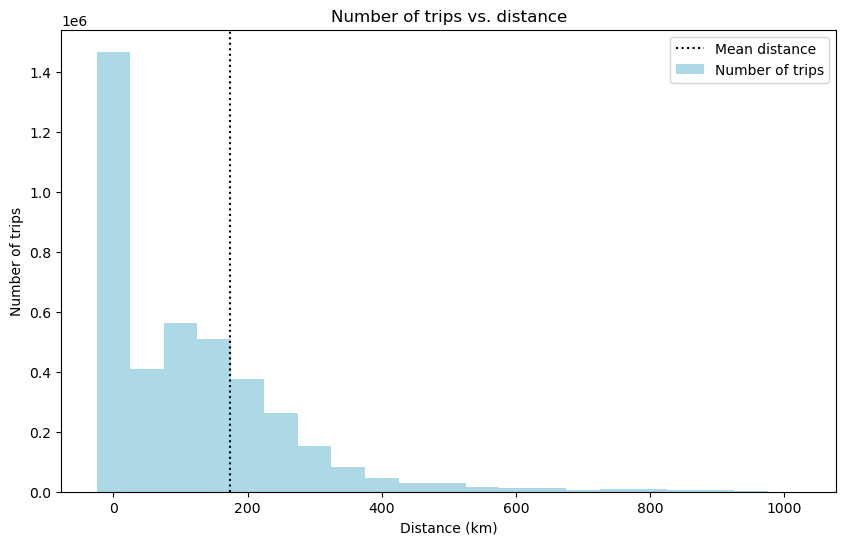

,No of trips
0,1468535.7
50,408192.0
100,564143.5
150,510538.3
200,374739.6
250,262205.4
300,152891.8
350,82112.3
400,46598.4
450,27767.2


In [5]:
distance_bins = np.arange(0, 1001, 50).tolist()


group = pd.DataFrame(index=distance_bins, columns=["No of trips"])
group["No of trips"] = 0

for row in city_list:
    for col in city_list:
        dis = Distance.loc[row, col]
        trips = weights.loc[row, col]
        
        bin_index = int(50 * (dis // 50))
        
        group.loc[bin_index, "No of trips"] += trips




fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(group.index, group["No of trips"], width=50, color="lightblue", label="Number of trips")


ax.axvline(x=174, color='black', linestyle='dotted', label="Mean distance")


ax.set_xlabel("Distance (km)")
ax.set_ylabel("Number of trips")
ax.set_title("Number of trips vs. distance")
ax.legend()

plt.show()
group


# Scenario 1

In [6]:
stop_possible_s1 = pd.DataFrame()  
Duration.astype(float)

for col in Duration.columns:
   
    stop_possible_s1[col] = Duration[col].apply(lambda x: 1 if 2.25<x<9 else 0)

stop_needed_s1 = stop_possible_s1.copy()


In [7]:
import osmnx as ox

bbox = (60, 50, 2, -10)  


cf =  '["highway"~"motorway|trunk"]'
G = ox.graph_from_bbox(*bbox, network_type="all", simplify=True, custom_filter=cf)

C:\Users\tedmu\AppData\Local\Temp\ipykernel_19444\4194376844.py:7: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(*bbox, network_type="all", simplify=True, custom_filter=cf)
c:\Users\tedmu\anaconda3\Lib\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 340 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


# Scenario 1

In [8]:
Scenario1 = pd.DataFrame(index=[station_list], columns=["Used", "No. Trips"], dtype=float)
Scenario1["Used"] = 0
Scenario1["No. Trips"] = 0
    

not_calculated_df = pd.DataFrame(columns=["Row", "Column"])

for column in stop_possible_s1.columns:
    for row in stop_possible_s1.index:
        if stop_possible_s1.loc[row, column] == 1:  
            available_station = Station_dur.loc[Station_dur[row] <= 4.5, [row]]
            available_station[column] = Station_dur.loc[Station_dur[column] <= 4.5, [column]]
            available_station["Total"] = available_station[row] + available_station[column]
            available_station.dropna(subset=["Total"], inplace=True)
            
            if available_station.empty:
                not_calculated_df.loc[len(not_calculated_df)] = {"Row": row, "Column": column}
                
                continue
            
            lowest_total_row = available_station.loc[available_station["Total"].idxmin()]
            Scenario1.loc[lowest_total_row.name, "Used"] += 1
            
            Scenario1.loc[lowest_total_row.name, "No. Trips"] += weights.loc[row, column]
        else:
            pass
Scenario1 = Scenario1[Scenario1["Used"] > 0]


C:\Users\tedmu\AppData\Local\Temp\ipykernel_19444\3036854721.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[19268.7]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Scenario1.loc[lowest_total_row.name, "No. Trips"] += weights.loc[row, column]


In [9]:

for i in not_calculated_df.index:
    row = not_calculated_df.loc[i, "Row"]
    column = not_calculated_df.loc[i, "Column"]
    stop_possible_s1.loc[row, column] += 1
count_s1 = stop_possible_s1[stop_possible_s1==1].count().sum()
print(stop_possible_s1[stop_possible_s1==1].count().sum())


1164


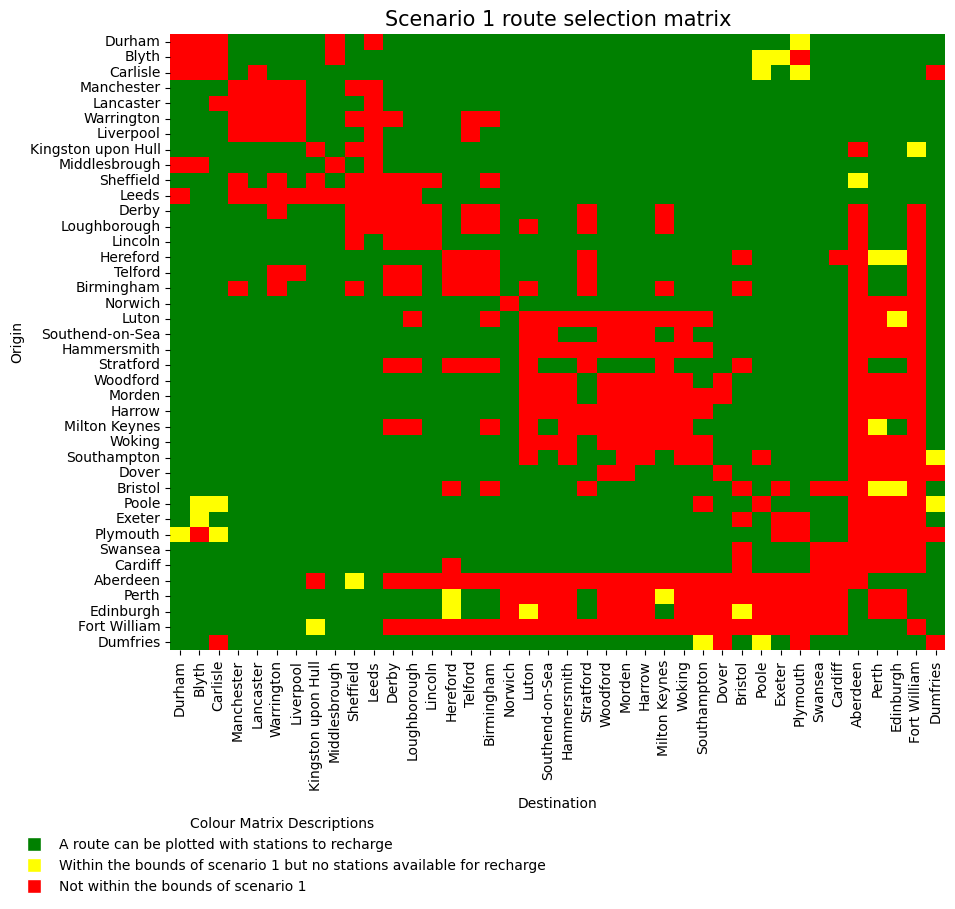

In [10]:


colors = {0: 'red', 1: 'green', 2: 'yellow'}

red_label = "Not within the bounds of scenario 1"
green_label = "A route can be plotted with stations to recharge"
yellow_label = "Within the bounds of scenario 1 but no stations available for recharge"


cmap = sns.color_palette([colors[i] for i in range(3)])

plt.figure(figsize=(10, 8))
sns.heatmap(stop_possible_s1, cmap=cmap, annot=False, fmt="d",cbar = False,  linewidths=0)

legend_squares = [plt.Line2D([0], [0], marker='s', color='w', markersize=10, markerfacecolor=color, label=label)
                  for label, color in [ (green_label, 'green'), (yellow_label, 'yellow'),(red_label, 'red')]]


plt.legend(handles=legend_squares, title="Colour Matrix Descriptions", loc="upper right", bbox_to_anchor=(.5, -0.25),frameon=False)

plt.xlabel('Destination')
plt.ylabel('Origin')
plt.title('Scenario 1 route selection matrix', fontsize=15)
plt.show()




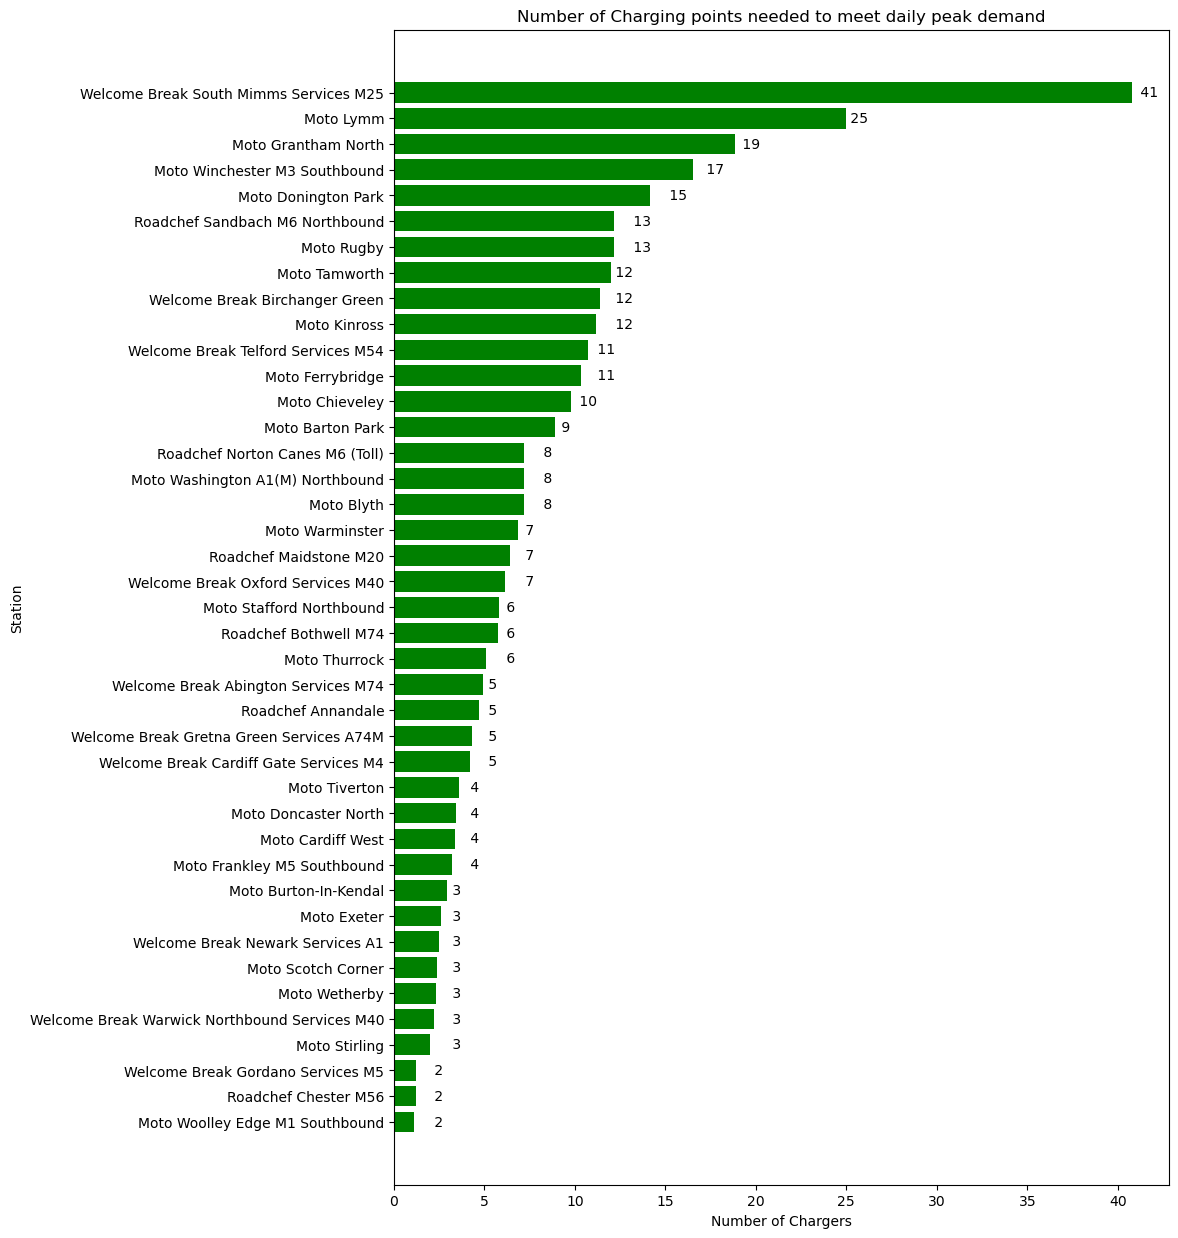

In [11]:
import math
Scenario1 = Scenario1.reset_index()



Scenario1.rename(columns={"level_0": "Station"}, inplace=True)
Scenario1 = Scenario1.astype({"Station": str,"Used": int, "No. Trips": int})
Scenario1["Daily"] = Scenario1["No. Trips"]/365
Scenario1["Chargers_needed"] = Scenario1["Daily"]*.0717
Scenario1_sorted_T= Scenario1.sort_values(by="No. Trips", ascending=True)
Scenario1_sorted_T = Scenario1_sorted_T[Scenario1_sorted_T["Chargers_needed"] >=1]

plt.figure(figsize=(10,15))
bars = plt.barh(Scenario1_sorted_T["Station"], Scenario1_sorted_T["Chargers_needed"], color='green')
plt.title('Number of Charging points needed to meet daily peak demand')
plt.ylabel('Station')
plt.xlabel('Number of Chargers')


for bar in bars:
    plt.text(math.ceil(bar.get_width()), bar.get_y() + bar.get_height() / 2, f' {int(bar.get_width())+1:}', 
             va='center', ha='left')

plt.show()


In [12]:
Scenario1_map = Scenario1.sort_values(by="No. Trips", ascending=False)
Scenario1_map = Scenario1.merge(station_loc, on="Station")
Scenario1_map = Scenario1_map[Scenario1_map["Daily"] > 48]
Scenario1_map



,Station,Used,No. Trips,Daily,Chargers_needed,Latitude,Longitude
0,Moto Barton Park,40,45368,124.295890,8.912015,54.466852,-1.663213
1,Moto Blyth,32,36539,100.106849,7.177661,53.387438,-1.060633
4,Moto Chieveley,48,49955,136.863014,9.813078,51.449036,-1.310933
5,Moto Doncaster North,2,17560,48.109589,3.449458,53.592216,-0.992259
6,Moto Donington Park,98,71961,197.153425,14.135901,52.821695,-1.308092
8,Moto Ferrybridge,14,52585,144.068493,10.329711,53.697522,-1.266743
10,Moto Grantham North,56,95859,262.627397,18.830384,52.948938,-0.678568
13,Moto Kinross,16,56780,155.561644,11.153770,56.209744,-3.439563
14,Moto Lymm,116,127034,348.038356,24.954350,53.358886,-2.505074
15,Moto Rugby,34,61806,169.331507,12.141069,52.410866,-1.250266


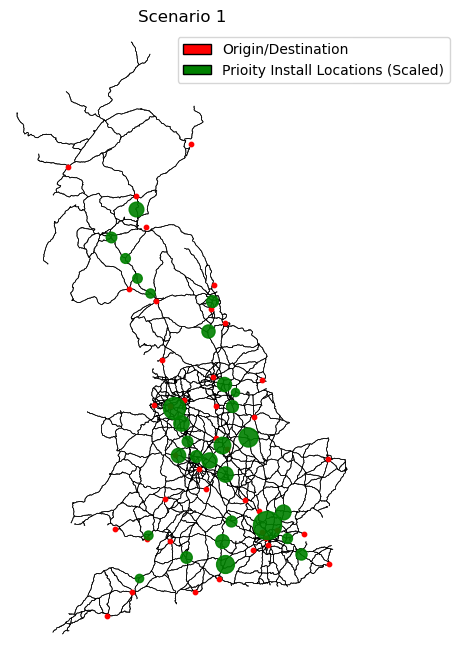

In [13]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch


Scenario1_map = Scenario1_map.sort_values(by="No. Trips", ascending=True)


fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, edge_color='black', edge_linewidth=0.5, node_color='black', bgcolor='white')

dark_blue = '#08306b'
medium_light_blue = '#a6bddb'

num_colors = len(Scenario1_map)  
colors = [dark_blue] + [dark_blue] * (num_colors - 2) + [medium_light_blue]


cmap = LinearSegmentedColormap.from_list("CustomBlue", colors, N=num_colors)


for index, city in cities_loc.iterrows():
    plt.scatter(city["Longitude"], city["Latitude"], color="#ff0000", s=10)


for index, (index, sta) in enumerate(Scenario1_map.iterrows()):
    color_index = min(index, num_colors - 1)  
    plt.scatter(sta["Longitude"], sta["Latitude"], color="green", s=sta["Chargers_needed"]*10, alpha=.9)



legend_elements = [Patch(facecolor='#ff0000', edgecolor='black', label='Origin/Destination'),
                   Patch(facecolor="green", edgecolor='black', label='Prioity Install Locations (Scaled)')]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title("Scenario 1")
plt.savefig("Photos/Scenario1.png", format="png", dpi=1200)


plt.show()


# Scenario 2

In [14]:
Duration = pd.read_csv("Duration_cleaned.csv", index_col="Town")
stop_possible_s2 = pd.DataFrame()  
Duration.astype(float)


for col in Duration.columns:
    
    stop_possible_s2[col] = Duration[col].apply(lambda x: 1 if 2.25 < x < 4.5 else 0)


In [15]:
Scenario2 = pd.DataFrame(index=[station_list], columns=["Used", "No. Trips"], dtype=float)
Scenario2["Used"] = 0
Scenario2["No. Trips"] = 0
    

not_calculated_df = pd.DataFrame(columns=["Row", "Column"])
for column in stop_possible_s2.columns:
    for row in stop_possible_s2.index:
        if stop_possible_s2.loc[row, column] == 1:  
            available_station = Station_dur.loc[Station_dur[row] <= 4.5, [row]]
            ori_des = Duration.loc[row, column]
            available_station["ori_des"] = ori_des
            
            available_station[column] = Station_dur.loc[Station_dur[column] <= 4.5, [column]]
            available_station["to_station"] = available_station["ori_des"] + available_station[column]
            
            available_station["Total"] = available_station[row] +available_station["to_station"]
            available_station.dropna(subset=["Total"], inplace=True)
            available_station = available_station[available_station["to_station"] <= 4.5]
            print(available_station["Total"])
            
            if available_station.empty:
                
                not_calculated_df.loc[len(not_calculated_df)] = {"Row": row, "Column": column}
                
                continue
            
            lowest_total_row = available_station.loc[available_station["Total"].idxmin()]
            
            Scenario2.loc[lowest_total_row.name, "Used"] += 1
            
            
            Scenario2.loc[lowest_total_row.name, "No. Trips"] += weights.loc[row, column]
        else:
            pass

Station
Moto Barton Park                    5.871558
Moto Leeming Bar                    6.001429
Moto Scotch Corner                  5.962468
Moto Washington A1(M) Northbound    6.287143
Moto Wetherby                       6.040390
Roadchef Durham A1(M)               5.910519
Name: Total, dtype: float64
Station
Moto Barton Park                    6.101429
Moto Leeming Bar                    6.205325
Moto Scotch Corner                  6.192338
Moto Washington A1(M) Northbound    6.491039
Moto Wetherby                       6.270260
Roadchef Durham A1(M)               6.140390
Name: Total, dtype: float64
Station
Moto Barton Park                    6.857013
Moto Leeming Bar                    6.973896
Moto Scotch Corner                  6.947922
Moto Washington A1(M) Northbound    7.259610
Roadchef Durham A1(M)               6.908961
Name: Total, dtype: float64
Station
Moto Barton Park                    5.566753
Moto Ferrybridge                    5.683636
Moto Leeming Bar             

C:\Users\tedmu\AppData\Local\Temp\ipykernel_19444\3610471904.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16341.7]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Scenario2.loc[lowest_total_row.name, "No. Trips"] += weights.loc[row, column]


Station
Moto Washington A1(M) Northbound    7.125844
Roadchef Durham A1(M)               7.164805
Name: Total, dtype: float64
Station
Moto Barton Park                    6.062468
Moto Leeming Bar                    6.581948
Moto Scotch Corner                  6.114416
Moto Washington A1(M) Northbound    6.036494
Roadchef Durham A1(M)               6.101429
Name: Total, dtype: float64
Station
Moto Washington A1(M) Northbound    7.329740
Roadchef Durham A1(M)               7.394675
Name: Total, dtype: float64
Station
Moto Washington A1(M) Northbound    8.088312
Roadchef Durham A1(M)               8.153247
Name: Total, dtype: float64
Station
Moto Barton Park                    6.767013
Moto Scotch Corner                  6.844935
Moto Washington A1(M) Northbound    6.741039
Roadchef Durham A1(M)               6.780000
Name: Total, dtype: float64
Station
Moto Barton Park                    6.446234
Moto Scotch Corner                  6.524156
Moto Washington A1(M) Northbound    6.420260
Ro

In [16]:
Scenario2 = Scenario2[Scenario2["Used"] > 0]
for i in not_calculated_df.index:
    row = not_calculated_df.loc[i, "Row"]
    column = not_calculated_df.loc[i, "Column"]
    stop_possible_s2.loc[row, column] += 1

count_s2 = stop_possible_s2[stop_possible_s2==1].count().sum()
print(stop_possible_s2[stop_possible_s2==1].count().sum())


443


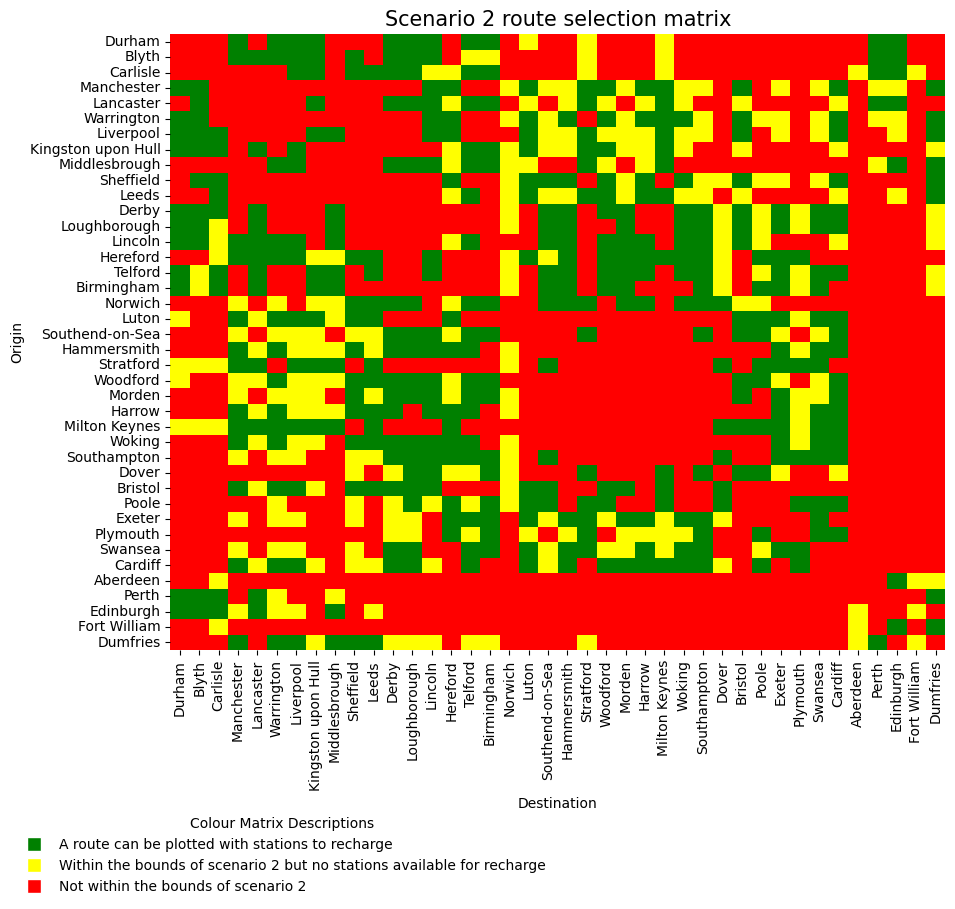

In [17]:

colors = {0: 'red', 1: 'green', 2: 'yellow'}

red_label = "Not within the bounds of scenario 2"
green_label = "A route can be plotted with stations to recharge"
yellow_label = "Within the bounds of scenario 2 but no stations available for recharge"


cmap = sns.color_palette([colors[i] for i in range(3)])

plt.figure(figsize=(10, 8))
sns.heatmap(stop_possible_s2, cmap=cmap, annot=False, fmt="d",cbar = False,  linewidths=0)

legend_squares = [plt.Line2D([0], [0], marker='s', color='w', markersize=10, markerfacecolor=color, label=label)
                  for label, color in [ (green_label, 'green'), (yellow_label, 'yellow'),(red_label, 'red')]]


plt.legend(handles=legend_squares, title="Colour Matrix Descriptions", loc="upper right", bbox_to_anchor=(.5, -0.25),frameon=False)

plt.xlabel('Destination')
plt.ylabel('Origin')
plt.title('Scenario 2 route selection matrix', fontsize=15)
plt.show()



In [18]:
Scenario2 = Scenario2.reset_index()


Scenario2.rename(columns={"level_0": "Station"}, inplace=True)
Scenario2 = Scenario2.astype({"Station": str,"Used": int, "No. Trips": int})
Scenario2["Daily"] = Scenario2["No. Trips"]/365
Scenario2["Chargers_needed"] = Scenario2["Daily"]*.0717
Scenario2_sorted_T= Scenario2.sort_values(by="Chargers_needed", ascending=True)
Scenario2_sorted_T = Scenario2_sorted_T[Scenario2_sorted_T["Chargers_needed"] >=1]
Scenario2_sorted_T



,Station,Used,No. Trips,Daily,Chargers_needed
2,Moto Blyth,5,5463,14.967123,1.073143
26,Moto Tamworth,4,5902,16.169863,1.159379
51,Welcome Break Gretna Green Services A74M,8,6244,17.106849,1.226561
16,Moto Leigh Delamere Eastbound,2,6341,17.372603,1.245616
60,Welcome Break Michaelwood Southbound Services M5,5,6780,18.575342,1.331852
3,Moto Burton-In-Kendal,4,6829,18.709589,1.341478
28,Moto Tiverton,12,6830,18.712329,1.341674
56,Welcome Break Birchanger Green,4,6878,18.843836,1.351103
7,Moto Doncaster North,5,7073,19.378082,1.389408
27,Moto Thurrock,5,7122,19.512329,1.399034


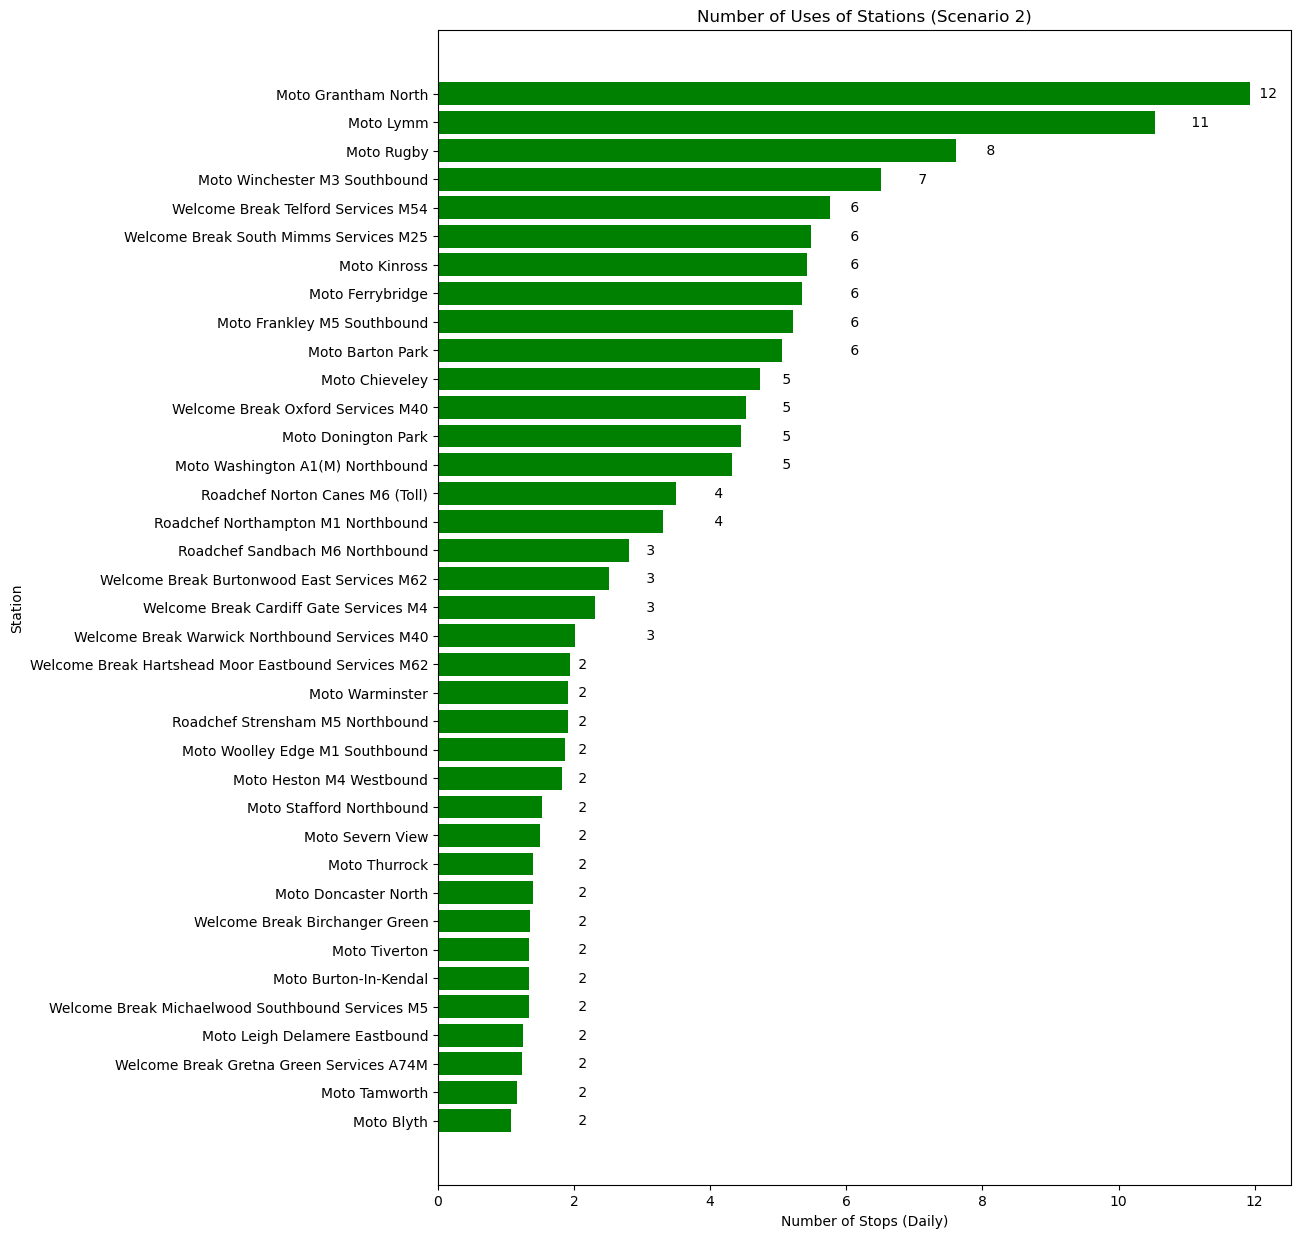

In [19]:



plt.figure(figsize=(11, 15))
bars = plt.barh(Scenario2_sorted_T["Station"], Scenario2_sorted_T["Chargers_needed"], color='green')
plt.title('Number of Uses of Stations (Scenario 2)')
plt.ylabel('Station')
plt.xlabel('Number of Stops (Daily)')


for bar in bars:
    plt.text(math.ceil(bar.get_width()), bar.get_y() + bar.get_height() / 2, f' {int(bar.get_width())+1:}', 
             va='center', ha='left')

plt.show()


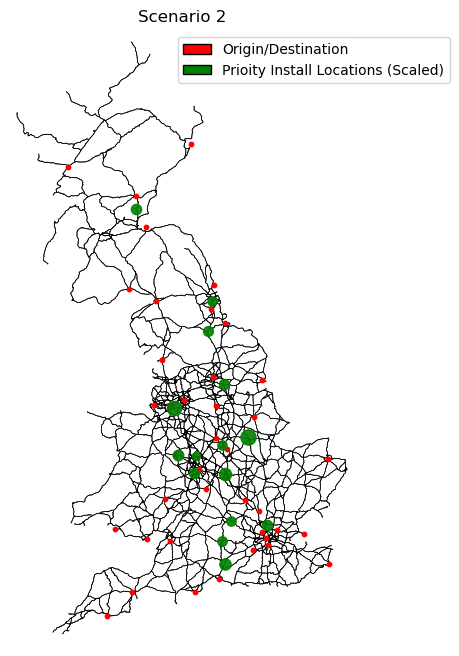

In [20]:
Scenario2_map = Scenario2.sort_values(by="No. Trips", ascending=False)
Scenario2_map = Scenario2.merge(station_loc, on="Station")
Scenario2_map = Scenario2_map[Scenario2_map["Daily"] > 48]

Scenario2_map = Scenario2_map.sort_values(by="No. Trips", ascending=True)



fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, edge_color='black', edge_linewidth=0.5, node_color='black', bgcolor='white')

dark_blue = '#08306b'
medium_light_blue = '#a6bddb'

num_colors = len(Scenario1_map)  
colors = [dark_blue] + [dark_blue] * (num_colors - 2) + [medium_light_blue]


cmap = LinearSegmentedColormap.from_list("CustomBlue", colors, N=num_colors)


for index, city in cities_loc.iterrows():
    plt.scatter(city["Longitude"], city["Latitude"], color="#ff0000", s=10)


for index, (index, sta) in enumerate(Scenario2_map.iterrows()):
    color_index = min(index, num_colors - 1) 
    plt.scatter(sta["Longitude"], sta["Latitude"], color="green", s=sta["Chargers_needed"]*10, alpha=.9)



legend_elements = [Patch(facecolor='#ff0000', edgecolor='black', label='Origin/Destination'),
                   Patch(facecolor="green", edgecolor='black', label='Prioity Install Locations (Scaled)')]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title("Scenario 2")
plt.savefig("Photos/Scenario2.png", format="png", dpi=1200)


plt.show()

# Scenario 3

In [21]:
Duration = pd.read_csv("Duration_cleaned.csv", index_col="Town")
stop_possible_s3 = pd.DataFrame()  
Duration.astype(float)


for col in Duration.columns:
    stop_possible_s3[col] = Duration[col].apply(lambda x: 1 if 4.5 < x < 6.25 else 0)




In [22]:
weights_un = pd.read_csv("no_of_trips.csv", index_col="Location_Name")

for col in city_list:
    for row in city_list:
        diff = weights_un.loc[row,col] - weights_un.loc[col, row]
        if diff >= 0:
            weights_un.loc[col, row] *= 0.3
        else:
            weights_un.loc[row, col] *- 0.3
weights_un


,Durham,Blyth,Carlisle,Manchester,Lancaster,Warrington,Liverpool,Kingston upon Hull,Middlesbrough,Sheffield,...,Exeter,Plymouth,Swansea,Cardiff,Aberdeen,Perth,Edinburgh,Fort William,Dumfries,Total
Location_Name,,,,,,,,,,,,,,,,,,,,,
Durham,29268.3,4390.2,1463.4,146.4,146.4,146.4,146.4,1463.4,9756.0,731.7,...,146.4,146.4,146.4,146.4,146.4,146.4,146.4,146.4,146.4,165854.0
Blyth,14634.0,19024.5,4878.0,146.4,146.4,146.4,146.4,731.7,731.7,146.4,...,146.4,146.4,146.4,146.4,146.4,146.4,1463.4,146.4,146.4,107317.0
Carlisle,4878.0,731.7,16097.7,4878.0,1463.4,146.4,731.7,146.4,146.4,146.4,...,146.4,146.4,146.4,146.4,146.4,146.4,1463.4,4878.0,1463.4,102439.0
Manchester,4878.0,2439.0,731.7,48292.8,2926.8,2926.8,4390.2,1463.4,731.7,1463.4,...,146.4,146.4,731.7,731.7,146.4,146.4,146.4,731.7,146.4,268293.0
Lancaster,488.0,488.0,4878.0,9756.0,32195.1,1463.4,2926.8,731.7,4878.0,4878.0,...,146.4,146.4,146.4,146.4,146.4,146.4,4878.0,1463.4,146.4,185366.0
Warrington,488.0,488.0,488.0,9756.0,4878.0,21951.3,1463.4,731.7,146.4,2439.0,...,146.4,146.4,4878.0,1463.4,146.4,146.4,146.4,731.7,146.4,165854.0
Liverpool,488.0,488.0,4878.0,14634.0,9756.0,9756.0,23414.7,1463.4,146.4,731.7,...,146.4,146.4,1463.4,1463.4,146.4,146.4,146.4,146.4,146.4,185366.0
Kingston upon Hull,4878.0,4878.0,488.0,9756.0,4878.0,4878.0,4878.0,49756.2,2926.8,19512.0,...,146.4,146.4,146.4,146.4,146.4,146.4,146.4,146.4,146.4,312195.0
Middlesbrough,1463.4,2439.0,488.0,4878.0,731.7,488.0,488.0,14634.0,27804.9,1463.4,...,146.4,146.4,146.4,146.4,146.4,146.4,146.4,146.4,146.4,170732.0


In [23]:
Scenario3 = pd.DataFrame(index=[station_list], columns=["Used", "No. Trips"], dtype=float)
Scenario3["Used"] = 0
Scenario3["No. Trips"] = 0
    
not_calculated_df = pd.DataFrame(columns=["Row", "Column"])

for column in stop_possible_s3.columns:
    for row in stop_possible_s3.index:
        if stop_possible_s3.loc[row, column] == 1:  
            available_station = Station_dur.loc[Station_dur[row] <= 4.5, [row]]
            available_station[column] = Station_dur.loc[Station_dur[column] <= 2.25, [column]]
            available_station["Total"] = available_station[row] + available_station[column]
            available_station.dropna(subset=["Total"], inplace=True)
            
            if available_station.empty:
                not_calculated_df.loc[len(not_calculated_df)] = {"Row": row, "Column": column}
                
                continue
            
            lowest_total_row = available_station.loc[available_station["Total"].idxmin()]
            Scenario3.loc[lowest_total_row.name, "Used"] += 1
            
            Scenario3.loc[lowest_total_row.name, "No. Trips"] += weights_un.loc[row, column]
        else:
            pass
Scenario3 = Scenario3[Scenario3["Used"] > 0]

C:\Users\tedmu\AppData\Local\Temp\ipykernel_19444\4081663902.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[146.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Scenario3.loc[lowest_total_row.name, "No. Trips"] += weights_un.loc[row, column]


In [24]:
for i in not_calculated_df.index:
    row = not_calculated_df.loc[i, "Row"]
    column = not_calculated_df.loc[i, "Column"]
    stop_possible_s3.loc[row, column] += 1

count_s3 = stop_possible_s3[stop_possible_s3==1].count().sum()
print(stop_possible_s3[stop_possible_s3==1].count().sum())


46


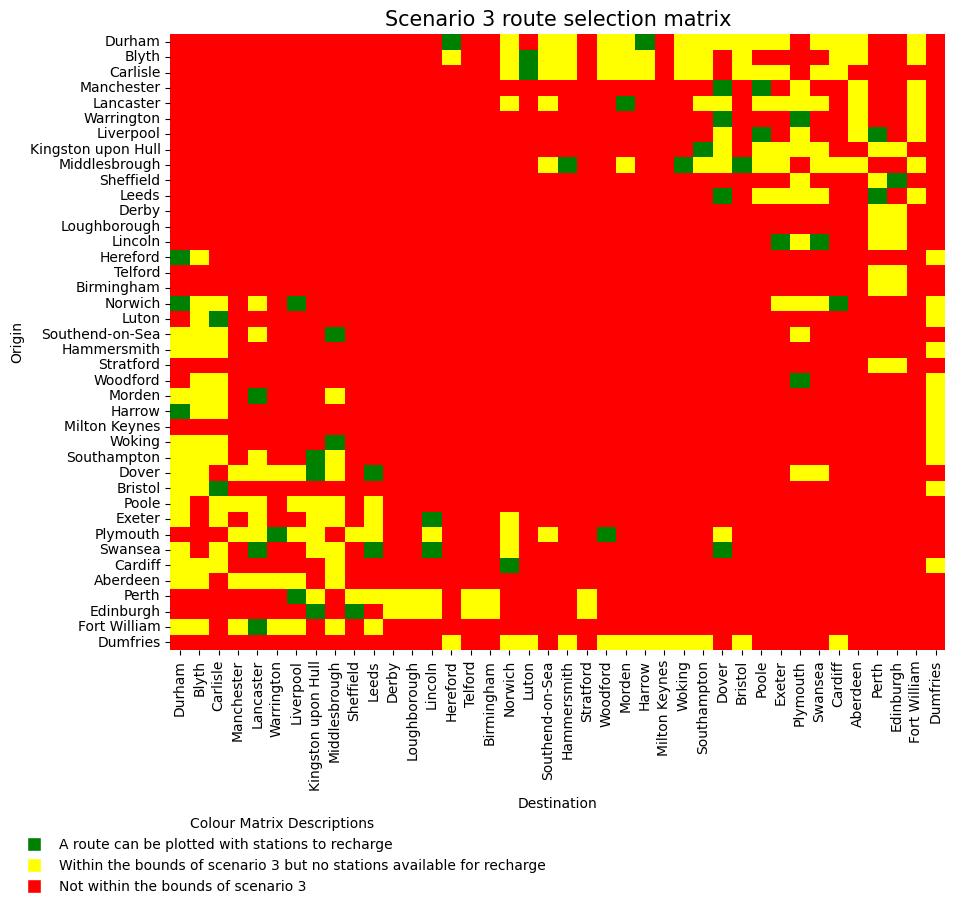

In [25]:

colors = {0: 'red', 1: 'green', 2: 'yellow'}

red_label = "Not within the bounds of scenario 3"
green_label = "A route can be plotted with stations to recharge"
yellow_label = "Within the bounds of scenario 3 but no stations available for recharge"


cmap = sns.color_palette([colors[i] for i in range(3)])

plt.figure(figsize=(10, 8))
sns.heatmap(stop_possible_s3, cmap=cmap, annot=False, fmt="d",cbar = False,  linewidths=0)

legend_squares = [plt.Line2D([0], [0], marker='s', color='w', markersize=10, markerfacecolor=color, label=label)
                  for label, color in [ (green_label, 'green'), (yellow_label, 'yellow'),(red_label, 'red')]]


plt.legend(handles=legend_squares, title="Colour Matrix Descriptions", loc="upper right", bbox_to_anchor=(.5, -0.25),frameon=False)

plt.xlabel('Destination')
plt.ylabel('Origin')
plt.title('Scenario 3 route selection matrix', fontsize=15)
plt.show()


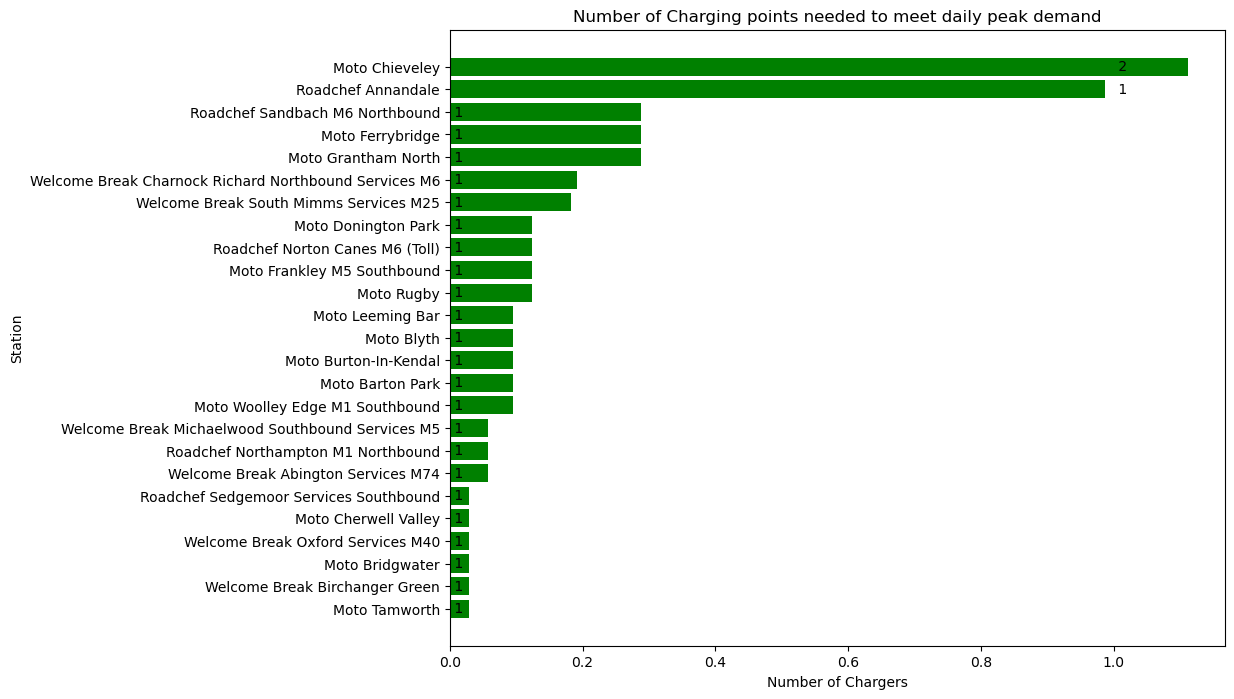

In [26]:
Scenario3 = Scenario3.reset_index()


Scenario3.rename(columns={"level_0": "Station"}, inplace=True)
Scenario3 = Scenario3.astype({"Station": str,"Used": int, "No. Trips": int})
Scenario3["Daily"] = Scenario3["No. Trips"]/365
Scenario3["Chargers_needed"] = Scenario3["Daily"]*.0717
Scenario3_sorted_T= Scenario3.sort_values(by="No. Trips", ascending=True)
Scenario3_sorted_T = Scenario3_sorted_T[Scenario3_sorted_T["Chargers_needed"] >0]

plt.figure(figsize=(10,8))
bars = plt.barh(Scenario3_sorted_T["Station"], Scenario3_sorted_T["Chargers_needed"], color='green')
plt.title('Number of Charging points needed to meet daily peak demand')
plt.ylabel('Station')
plt.xlabel('Number of Chargers')


for bar in bars:
    plt.text(math.ceil(bar.get_width()-.8), bar.get_y() + bar.get_height() / 2, f' {int(bar.get_width()+1):}', 
             va='center', ha='left')



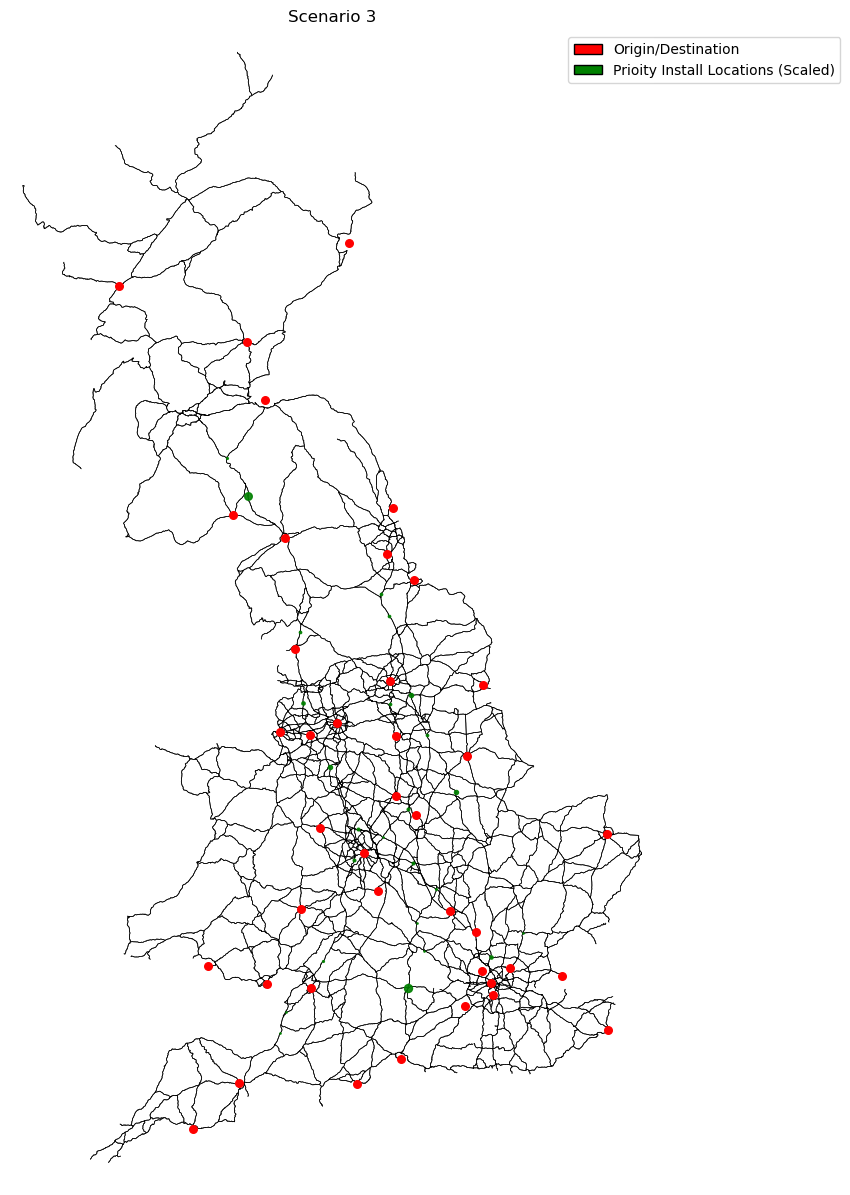

In [29]:
Scenario3_map = Scenario3.sort_values(by="No. Trips", ascending=False)
Scenario3_map = Scenario3.merge(station_loc, on="Station")
Scenario3_map = Scenario3_map[Scenario3_map["Daily"] > 0]
Scenario3_map

Scenario3_map = Scenario3_map.sort_values(by="No. Trips", ascending=True)




fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, edge_color='black', edge_linewidth=0.5, node_color='black', bgcolor='white', figsize=(10, 15))

dark_blue = '#08306b'
medium_light_blue = '#a6bddb'

num_colors = len(Scenario3_map)  
colors = [dark_blue] + [dark_blue] * (num_colors - 2) + [medium_light_blue]


cmap = LinearSegmentedColormap.from_list("CustomBlue", colors, N=num_colors)


for index, city in cities_loc.iterrows():
    plt.scatter(city["Longitude"], city["Latitude"], color="#ff0000", s=30)


for index, (index, sta) in enumerate(Scenario3_map.iterrows()):
    color_index = min(index, num_colors - 1)  
    plt.scatter(sta["Longitude"], sta["Latitude"], color="green", s=sta["Chargers_needed"]*30, alpha=.9)



legend_elements = [Patch(facecolor='#ff0000', edgecolor='black', label='Origin/Destination'),
                   Patch(facecolor="green", edgecolor='black', label='Prioity Install Locations (Scaled)')]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title("Scenario 3")
plt.savefig("Photos/Scenario3.png", format="png", dpi=1200)


plt.show()

# Final

In [ ]:

s1_weighing  = count_s1/(count_s1+count_s3)
print(s1_weighing)


weights_s1 = weights
weights_s2 = weights
weights_s3 = weights

for col in weights.columns:
    for row in weights.index:
        if 4.5<= Duration.loc[row, col] <=9:
            weights_s1.loc[row, col] /= s1_weighing
            weights_s3.loc[row, col] /= (1-s1_weighing)
        else:
            continue



0.9619834710743802


In [ ]:
stop_possible_final = pd.DataFrame(index = city_list, columns = city_list)
stop_possible_final = stop_possible_final.fillna(0)

Duplicate_routes = pd.DataFrame(columns = ["row","col"])

for col in city_list:
    for row in city_list:

        if stop_possible_final.loc[row, col] == 1:
            Duplicate_routes.loc[len(Duplicate_routes)] = {"row": row, "col": col}
        
        if stop_possible_s1.loc[row, col] == 1:
            stop_possible_final.loc[row, col] = 1
        if stop_possible_s2.loc[row, col] == 1:
            stop_possible_final.loc[row, col] = 2
        if stop_possible_s3.loc[row, col] == 1:
            stop_possible_final.loc[row, col] = 3

stop_possible_final_map = stop_possible_final.replace([1,2,3], [1,1,1])

for col in city_list:
    for row in city_list:
        if Duration.loc[row, col] < 2.25:
            stop_possible_final_map.loc[row, col] = 5
        elif Duration.loc[row, col] > 9:
            stop_possible_final_map.loc[row, col] = 6

stop_possible_final_map.replace([5,6], [2,3], inplace=True)
stop_possible_final_map


C:\Users\tedmu\AppData\Local\Temp\ipykernel_9676\985026862.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stop_possible_final = stop_possible_final.fillna(0)


,Durham,Blyth,Carlisle,Manchester,Lancaster,Warrington,Liverpool,Kingston upon Hull,Middlesbrough,Sheffield,...,Poole,Exeter,Plymouth,Swansea,Cardiff,Aberdeen,Perth,Edinburgh,Fort William,Dumfries
Durham,2,2,2,1,2,1,1,1,2,2,...,1,1,0,1,1,1,1,1,1,2
Blyth,2,2,2,1,1,1,1,1,2,1,...,0,0,0,1,1,1,1,1,1,2
Carlisle,2,2,2,2,2,2,1,1,2,1,...,0,1,0,1,1,1,1,1,1,2
Manchester,1,1,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
Lancaster,2,1,2,2,2,2,2,1,2,1,...,1,1,1,1,1,1,1,1,1,2
Warrington,1,1,2,2,2,2,2,2,1,2,...,1,1,1,1,1,1,1,1,1,1
Liverpool,1,1,1,2,2,2,2,1,1,2,...,1,1,1,1,1,1,1,1,1,1
Kingston upon Hull,1,1,1,2,1,2,1,2,2,2,...,1,1,1,1,1,0,1,1,0,1
Middlesbrough,2,2,2,2,2,1,1,2,2,2,...,1,1,1,1,1,1,1,1,1,1
Sheffield,2,1,1,2,2,2,2,2,2,2,...,1,1,1,1,1,0,1,1,1,1


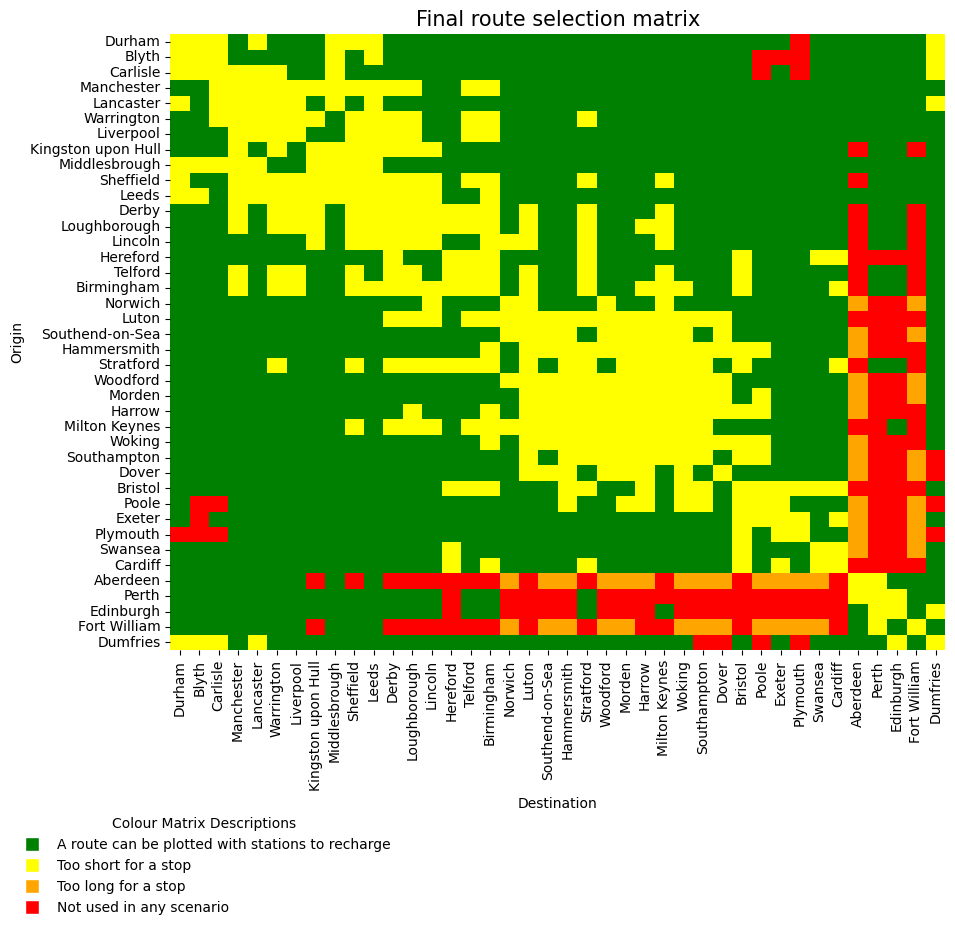

In [ ]:
colors = {0: 'red', 1: 'green', 2: 'yellow', 3: 'orange'}

red_label = "Not used in any scenario"
green_label = "A route can be plotted with stations to recharge"
orange_label = "Too long for a stop"
yellow_label = "Too short for a stop"


cmap = sns.color_palette([colors[i] for i in range(4)])

plt.figure(figsize=(10, 8))
sns.heatmap(stop_possible_final_map, cmap=cmap, annot=False, fmt="d",cbar = False,  linewidths=0)

legend_squares = [plt.Line2D([0], [0], marker='s', color='w', markersize=10, markerfacecolor=color, label=label)
                  for label, color in [ (green_label, 'green'), (yellow_label, 'yellow'), (orange_label, 'orange'),(red_label, 'red')]]


plt.legend(handles=legend_squares, title="Colour Matrix Descriptions", loc="upper right", bbox_to_anchor=(.3, -0.25),frameon=False)

plt.xlabel('Destination')
plt.ylabel('Origin')
plt.title('Final route selection matrix', fontsize=15)
plt.show()

In [ ]:
Scenario_final = pd.DataFrame(index=[station_list], columns=["Used", "No. Trips"], dtype=float)
Scenario_final["Used"] = 0
Scenario_final["No. Trips"] = 0
not_calculated_df = pd.DataFrame(columns=["Row", "Column"])
avaliable_station = pd.DataFrame()

for column in stop_possible_final.columns:
    for row in stop_possible_final.index:
        if stop_possible_final.loc[row, column] == 1:  
            available_station = Station_dur.loc[Station_dur[row] <= 4.5, [row]]
            available_station[column] = Station_dur.loc[Station_dur[column] <= 4.5, [column]]
            available_station["Total"] = available_station[row] + available_station[column]
            available_station.dropna(subset=["Total"], inplace=True)
            
            if available_station.empty:
                not_calculated_df.loc[len(not_calculated_df)] = {"Row": row, "Column": column}
                
                continue
            
            lowest_total_row = available_station.loc[available_station["Total"].idxmin()]
            Scenario_final.loc[lowest_total_row.name, "Used"] += 1
            
            Scenario_final.loc[lowest_total_row.name, "No. Trips"] += weights_s1.loc[row, column]
        if stop_possible_final.loc[row, column] == 2:
            available_station = Station_dur.loc[Station_dur[row] <= 4.5, [row]]
            ori_des = Duration.loc[row, column]
            available_station["ori_des"] = ori_des
            
            available_station[column] = Station_dur.loc[Station_dur[column] <= 4.5, [column]]
            available_station["to_station"] = available_station["ori_des"] + available_station[column]
            
            available_station["Total"] = available_station[row] +available_station["to_station"]
            available_station.dropna(subset=["Total"], inplace=True)
            available_station = available_station[available_station["to_station"] <= 4.5]
            
            
            if available_station.empty:
                
                not_calculated_df.loc[len(not_calculated_df)] = {"Row": row, "Column": column}
                
                continue
            
            lowest_total_row = available_station.loc[available_station["Total"].idxmin()]
            
            Scenario_final.loc[lowest_total_row.name, "Used"] += 1
            
            
            Scenario_final.loc[lowest_total_row.name, "No. Trips"] += weights_s2.loc[row, column]
        if stop_possible_final.loc[row, column] == 3:
            available_station = Station_dur.loc[Station_dur[row] <= 4.5, [row]]
            available_station[column] = Station_dur.loc[Station_dur[column] <= 2.25, [column]]
            available_station["Total"] = available_station[row] + available_station[column]
            available_station.dropna(subset=["Total"], inplace=True)
            
            if available_station.empty:
                not_calculated_df.loc[len(not_calculated_df)] = {"Row": row, "Column": column}
                
                continue
            
            lowest_total_row = available_station.loc[available_station["Total"].idxmin()]
            Scenario_final.loc[lowest_total_row.name, "Used"] += 1
            
            Scenario_final.loc[lowest_total_row.name, "No. Trips"] += weights_s3.loc[row, column]
        else:
            pass
Scenario_final = Scenario_final[Scenario_final["No. Trips"] > 0].sort_values(by="No. Trips", ascending=False)
Scenario_final
Scenario_final = Scenario_final.reset_index()



C:\Users\tedmu\AppData\Local\Temp\ipykernel_9676\4038584198.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[19268.7]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Scenario_final.loc[lowest_total_row.name, "No. Trips"] += weights_s2.loc[row, column]


In [ ]:
Scenario1_map.set_index("Station", inplace=True)
Scenario2_map.set_index("Station", inplace=True)
Scenario3_map.set_index("Station", inplace=True)
station_loc.set_index("Station", inplace=True)

In [ ]:

Scenario_final = pd.DataFrame(index=station_list, columns=["s1", "s2", "s3"], dtype=float)


for row in station_list:
    if row in Scenario1_map.index:
        Scenario_final.loc[row, "s1"] = Scenario1_map.loc[row, "Chargers_needed"]
    else:
        Scenario_final.loc[row, "s1"] = 0
    
    if row in Scenario2_map.index:
        Scenario_final.loc[row, "s2"] = Scenario2_map.loc[row, "Chargers_needed"]
    else:
        Scenario_final.loc[row, "s2"] = 0
    
    if row in Scenario3_map.index:
        Scenario_final.loc[row, "s3"] = Scenario3_map.loc[row, "Chargers_needed"]
    else:
        Scenario_final.loc[row, "s3"] = 0


Scenario_final = Scenario_final.sort_values(by="s1", ascending=False)

Scenario_final["s1"] = Scenario_final["s1"]*s1_weighing
Scenario_final["s3"] = Scenario_final["s3"]*(1-s1_weighing)
Scenario_final["final"] = Scenario_final["s1"] + Scenario_final["s2"] + Scenario_final["s3"]
print("s1 weighting", s1_weighing)
print("s3 weighting", 1-s1_weighing)

Scenario_final

s1 weighting 0.9619834710743802
s3 weighting 0.0380165289256198


,s1,s2,s3,final
Welcome Break South Mimms Services M25,39.233100,5.481416,0.006923,44.721439
Moto Lymm,24.005672,10.540882,0.000000,34.546555
Moto Grantham North,18.114519,11.930094,0.010933,30.055546
Moto Winchester M3 Southbound,15.901297,6.516057,0.000000,22.417353
Moto Donington Park,13.598503,4.456008,0.004735,18.059245
...,...,...,...,...
Roadchef Clacket Lane M25 Westbound,0.000000,0.000000,0.000000,0.000000
Roadchef Durham A1(M),0.000000,0.000000,0.000000,0.000000
Moto Hilton Park Northbound,0.000000,0.000000,0.000000,0.000000
Roadchef Killington Lake M6 Southbound,0.000000,0.000000,0.000000,0.000000


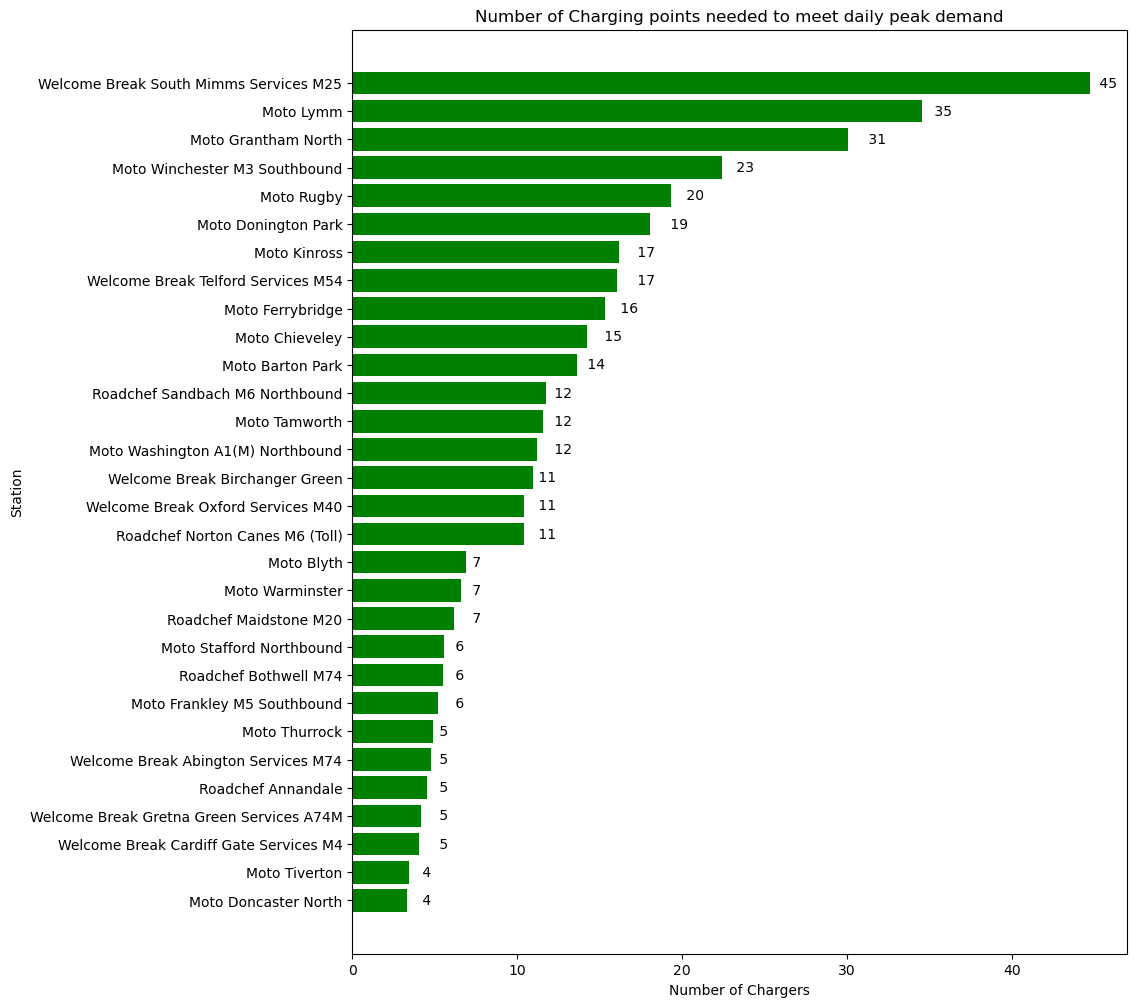

In [ ]:
Scenario_final = Scenario_final[Scenario_final["final"] > 2].sort_values(by="final", ascending=True)

plt.figure(figsize=(10,12))
bars = plt.barh(Scenario_final.index, Scenario_final["final"], color='green')
plt.title('Number of Charging points needed to meet daily peak demand')
plt.ylabel('Station')
plt.xlabel('Number of Chargers')


for bar in bars:
    plt.text(math.ceil(bar.get_width()), bar.get_y() + bar.get_height() / 2, f' {int(bar.get_width()+1):}', 
             va='center', ha='left')

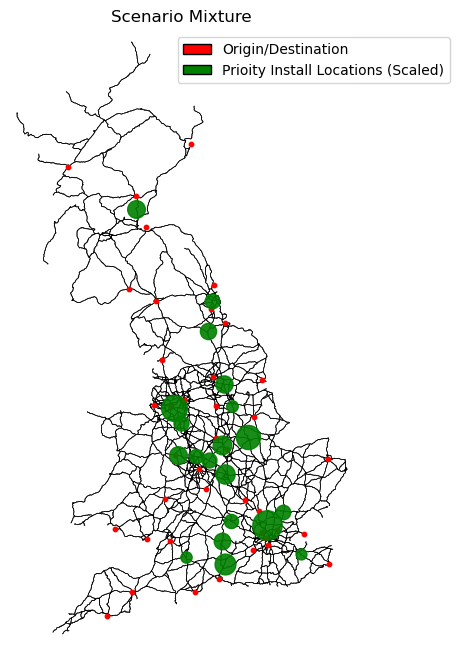

In [ ]:
Scenario_final_map = Scenario_final.sort_values(by="final", ascending=False)
Scenario_final_map = Scenario_final.merge(station_loc, left_index=True, right_index=True)



Scenario_final_map = Scenario_final_map.sort_values(by="final", ascending=False)
Scenario_final_map = Scenario_final_map[:20]


fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, edge_color='black', edge_linewidth=0.5, node_color='black', bgcolor='white')

dark_blue = '#08306b'
medium_light_blue = '#a6bddb'

num_colors = len(Scenario_final_map)  
colors = [dark_blue] + [dark_blue] * (num_colors - 2) + [medium_light_blue]


cmap = LinearSegmentedColormap.from_list("CustomBlue", colors, N=num_colors)


for index, city in cities_loc.iterrows():
    plt.scatter(city["Longitude"], city["Latitude"], color="#ff0000", s=10)


for _, sta in Scenario_final_map.iterrows():
    plt.scatter(sta["Longitude"], sta["Latitude"], color="green", s=sta["final"]*10, alpha=.9)




legend_elements = [Patch(facecolor='#ff0000', edgecolor='black', label='Origin/Destination'),
                   Patch(facecolor="green", edgecolor='black', label='Prioity Install Locations (Scaled)')]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.title("Scenario Mixture")
plt.savefig("Photos/Scenario_final.png", format="png", dpi=1200)


plt.show()

In [ ]:
a1 = Duration[Duration < 2.25].count().sum()
print(a1)
a2 = Duration[Duration > 9].count().sum()
print(a2)
a3 = Duration[Duration>1].count().sum()
print(a3)
print(406/a3)
print(a2/a3)


406
48
1504
0.2699468085106383
0.031914893617021274
